In [1]:
 #from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, Multiply
from tensorflow.keras import backend as K
import cv2, numpy as np
import glob
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.activations import relu 
import keras as keras
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import  Input,Conv2D,BatchNormalization,Activation,Lambda,Subtract,concatenate,Add,add,Reshape

from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose,DepthwiseConv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import losses
from tensorflow.keras.layers import  Layer,Activation, Lambda, MaxPooling2D, UpSampling2D, Conv2DTranspose, SpatialDropout2D
import os
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from  sklearn.model_selection import train_test_split

#from tensorflow.python import debug as tf_debug
import imageio
import glob
from skimage import transform as tf

from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.image as plt_img
import scipy
import scipy
import skimage
import re
#import LRFinder
import math as m
import tensorflow as tf 
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler 
from tensorflow.keras import backend as K
from pathlib import Path
from keras import objectives

from tensorflow.keras import optimizers

import numpy as np
 
from keras import backend as K
from skimage.measure import compare_ssim, compare_psnr

from tensorflow.keras.utils import to_categorical

import cv2
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

tf.random.Generator = None 
import tensorflow_addons as tfa
from tensorflow.keras.datasets import  mnist, fashion_mnist

import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Model

Using TensorFlow backend.


In [2]:
def sampling(mu_log_variance):
    mu, log_variance = mu_log_variance
    epsilon = K.random_normal(shape=K.shape(mu), mean=0.0, stddev=1.0)
    random_sample = mu + K.exp(log_variance/2) * epsilon
    return random_sample

In [3]:
 

img_size = 28
num_channels = 1
latent_space_dim = 2

# Encoder
inp = Input(shape=(img_size, img_size, num_channels))

x1=Conv2D(1, kernel_size=3, strides=1, padding='same',activation="relu", kernel_initializer = 'he_normal')(inp)
#x1=BatchNormalization( )(x1)

x2=Conv2D(32, kernel_size=3, strides=1, padding='same',activation="relu", kernel_initializer = 'he_normal')(x1)
#x2=BatchNormalization( )(x2)

x3=Conv2D(64, kernel_size=3, strides=2, padding='same',activation="relu", kernel_initializer = 'he_normal')(x2)
#x3=BatchNormalization( )(x3)
 
x4=Conv2D(64, kernel_size=3, strides=2, padding='same',activation="relu", kernel_initializer = 'he_normal')(x3)
#x4=BatchNormalization( )(x4)

x4=Conv2D(64, kernel_size=3, strides=1, padding='same',activation="relu", kernel_initializer = 'he_normal')(x4)
#x4=BatchNormalization( )(x4) 

 
shape_in = K.int_shape(x4)[1:]
fl=  Flatten()(x4)

encoder_mu =  Dense(units=latent_space_dim)(fl)
encoder_log_variance =  Dense(units=latent_space_dim)(fl)

encoder_mu_log_variance_model = Model(inp, (encoder_mu, encoder_log_variance))



encoder_output = Lambda(sampling, output_shape=(2,))([encoder_mu, encoder_log_variance])

encoder = Model(inp, encoder_output)
encoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 1)    10          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
____________________________________________________________________________________________

In [4]:
dit = Input(shape=(latent_space_dim))

d1= Dense(units=np.prod(shape_in))(dit)
d_reshape = Reshape(target_shape=shape_in)(d1)

d4=Conv2DTranspose(64, kernel_size=3, strides=2, padding='same',activation="relu", kernel_initializer = 'he_normal')(d_reshape)
#d4=BatchNormalization( )(d4) 

d4=Conv2DTranspose(64, kernel_size=3, strides=1, padding='same',activation="relu", kernel_initializer = 'he_normal')(d4)
#d4=BatchNormalization( )(d4)

d3=Conv2DTranspose(64, kernel_size=3, strides=2, padding='same',activation="relu", kernel_initializer = 'he_normal')(d4)
#d3=BatchNormalization( )(d3)


d2=Conv2DTranspose(64, kernel_size=3, strides=1, padding='same',activation="relu", kernel_initializer = 'he_normal')(d3)
#d2=BatchNormalization( )(d2)

d1=Conv2DTranspose(1, kernel_size=3, strides=1, padding='same',activation="relu", kernel_initializer = 'he_normal')(d2)
 

decoder =  Model(dit, d1 )
decoder.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 64)        36928     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 64)        3692

In [5]:
vae_input =  Input(shape=(img_size, img_size, num_channels) )
vae_encoder_output = encoder(vae_input)
vae_decoder_output = decoder(vae_encoder_output)
vae =  Model(vae_input, vae_decoder_output )
vae.summary() 
 

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model_1 (Model)              (None, 2)                 105230    
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         157697    
Total params: 262,927
Trainable params: 262,927
Non-trainable params: 0
_________________________________________________________________


In [6]:
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 1000
        reconstruction_loss = K.mean(K.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * K.sum(1.0 + encoder_log_variance - K.square(encoder_mu) - K.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * K.sum(1.0 + encoder_log_variance - K.square(encoder_mu) - K.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss 

In [7]:
vae.compile(optimizer=Adam(lr=0.0005), loss=loss_func(encoder_mu, encoder_log_variance))

In [8]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = np.reshape(x_train, newshape=(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = np.reshape(x_test, newshape=(x_test.shape[0], x_train.shape[1], x_train.shape[2], 1))



In [9]:
vae.fit(x_train, x_train, epochs=30, batch_size=64, shuffle=True, validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 15s 251us/sample - loss: 52.7494 - val_loss: 47.3075
Epoch 2/30
60000/60000 [==============================] - 13s 209us/sample - loss: 46.2206 - val_loss: 45.1867
Epoch 3/30
60000/60000 [==============================] - 13s 208us/sample - loss: 44.3954 - val_loss: 43.9567
Epoch 4/30
60000/60000 [==============================] - 12s 203us/sample - loss: 43.3390 - val_loss: 43.2131
Epoch 5/30
60000/60000 [==============================] - 12s 203us/sample - loss: 42.6249 - val_loss: 42.5604
Epoch 6/30
60000/60000 [==============================] - 12s 203us/sample - loss: 42.0440 - val_loss: 42.2502
Epoch 7/30
60000/60000 [==============================] - 12s 208us/sample - loss: 41.5829 - val_loss: 41.7264
Epoch 8/30
60000/60000 [==============================] - 12s 207us/sample - loss: 41.1899 - val_loss: 41.3998
Epoch 9/30
60000/60000 [==============================] - 13s 

In [10]:
encoder.save("VAE_encoder.hdf5")
decoder.save("VAE_decoder.hdf5")
vae.save("VAE.hdf5")

In [11]:
 

# Preparing MNIST Dataset
(x_train, y_train), (x_test, y_test) =  keras.datasets.mnist.load_data()
x_test = x_test.astype("float32") / 255.0

x_test = np.reshape(x_test, newshape=(x_test.shape[0], x_train.shape[1], x_train.shape[2], 1))

encoded_data = encoder.predict(x_test)
decoded_data = decoder.predict(encoded_data)

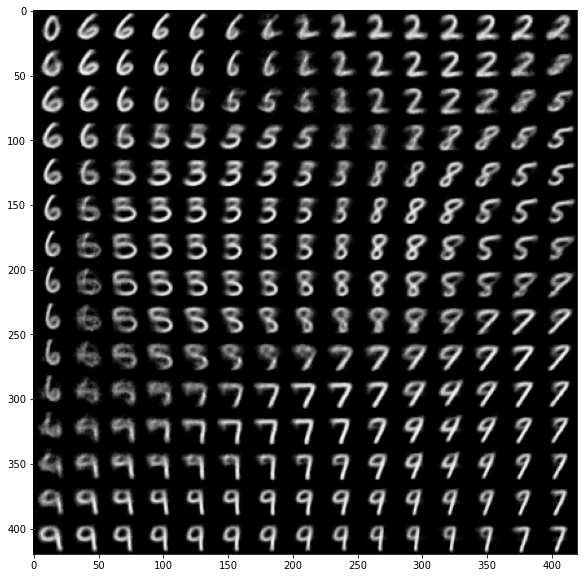

In [12]:
from scipy.stats import norm
n = 15 # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = np.squeeze(x_decoded)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()  